![](https://www.santander.co.uk/themes/custom/santander_web18/logo.svg)

[image-source](https://www.santander.co.uk/themes/custom/santander_web18/logo.svg)



## Main outline

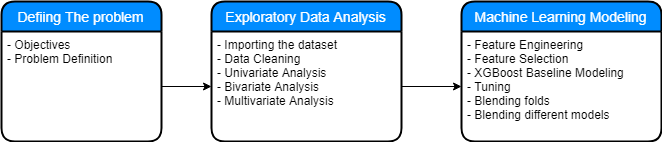

## Exploratory Data Analysis

![](http://blog.k2analytics.co.in/wp-content/uploads/2016/12/Exploratory_Data_Analysis.png)

[image-source](http://blog.k2analytics.co.in/wp-content/uploads/2016/12/Exploratory_Data_Analysis.png)

### Importing the dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.shape, test.shape

((200000, 202), (200000, 201))

In [4]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

At first glance we have many uncharacterized numerical features, their names has the prefix "var_" and they are 200 in numbers. There are so many variables that some histograms will shed light to their numerical appearance.

In [5]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

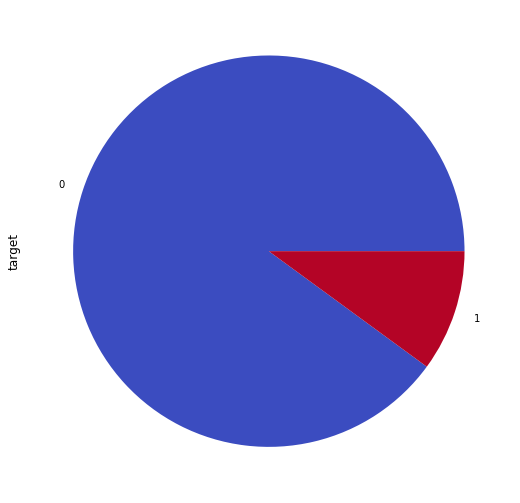

In [6]:
train['target'].value_counts().plot(kind="pie", figsize=(12,9), colormap="coolwarm")

Here we have a typical imbalanced dataset.

#### check for missing data

In [7]:
train.isna().sum().sum()

0

In [8]:
test.isna().sum().sum()

0

We have no NA values which is very nice!!

#### Splitting the numerical features

In [9]:
train.describe()
gc.collect();

In [10]:
numerical_features = train.columns[2:]

Distributions columns


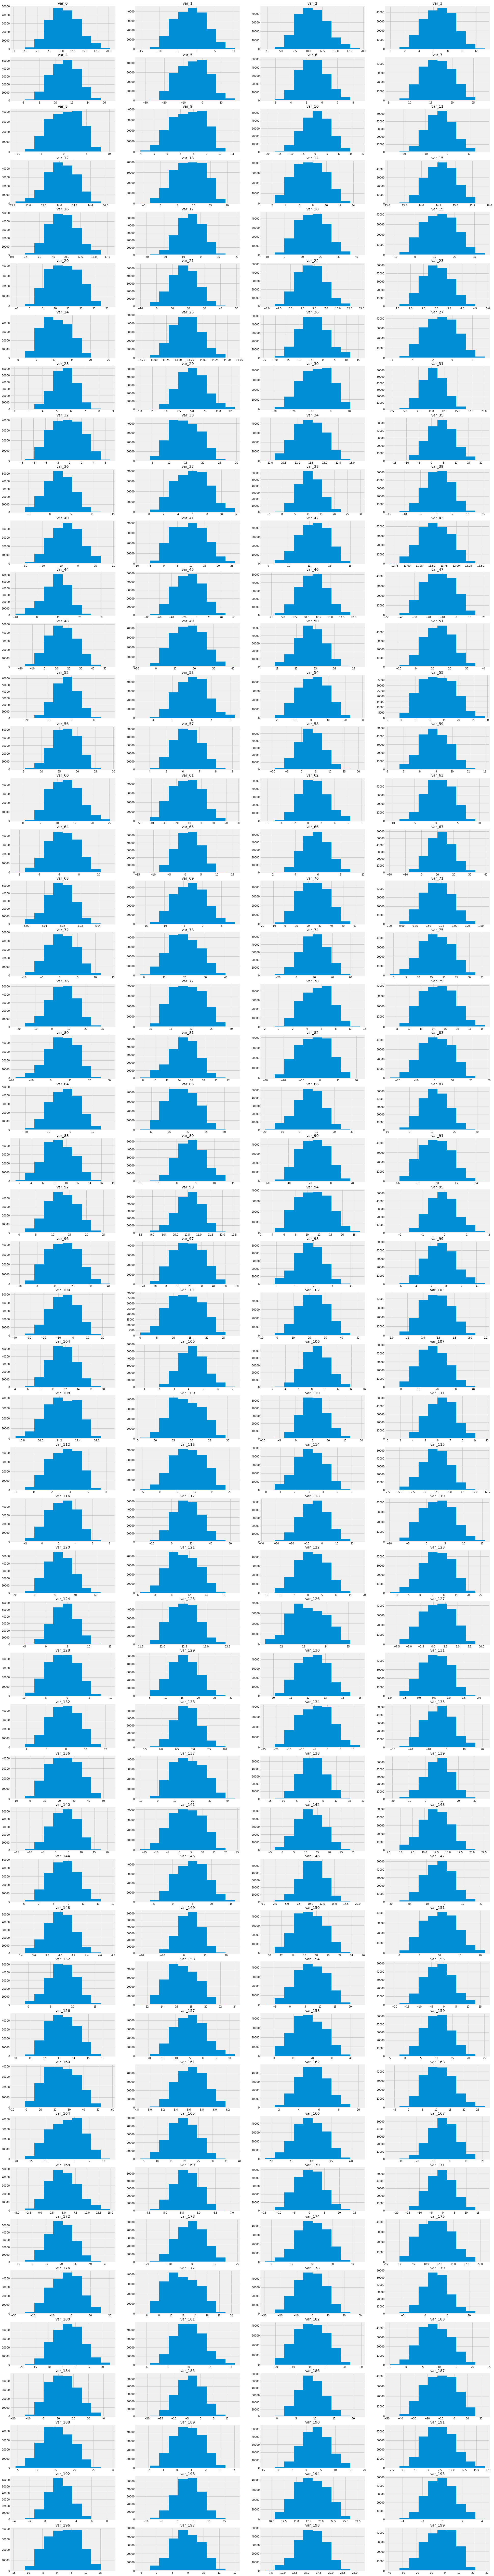

In [11]:
print('Distributions columns')
plt.figure(figsize=(30, 185))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[col]) 
    plt.title(col)
gc.collect();

Almost all features shows a normal distribution shape. Lets see the distributions for for all numerical features per each class.

Distributions columns


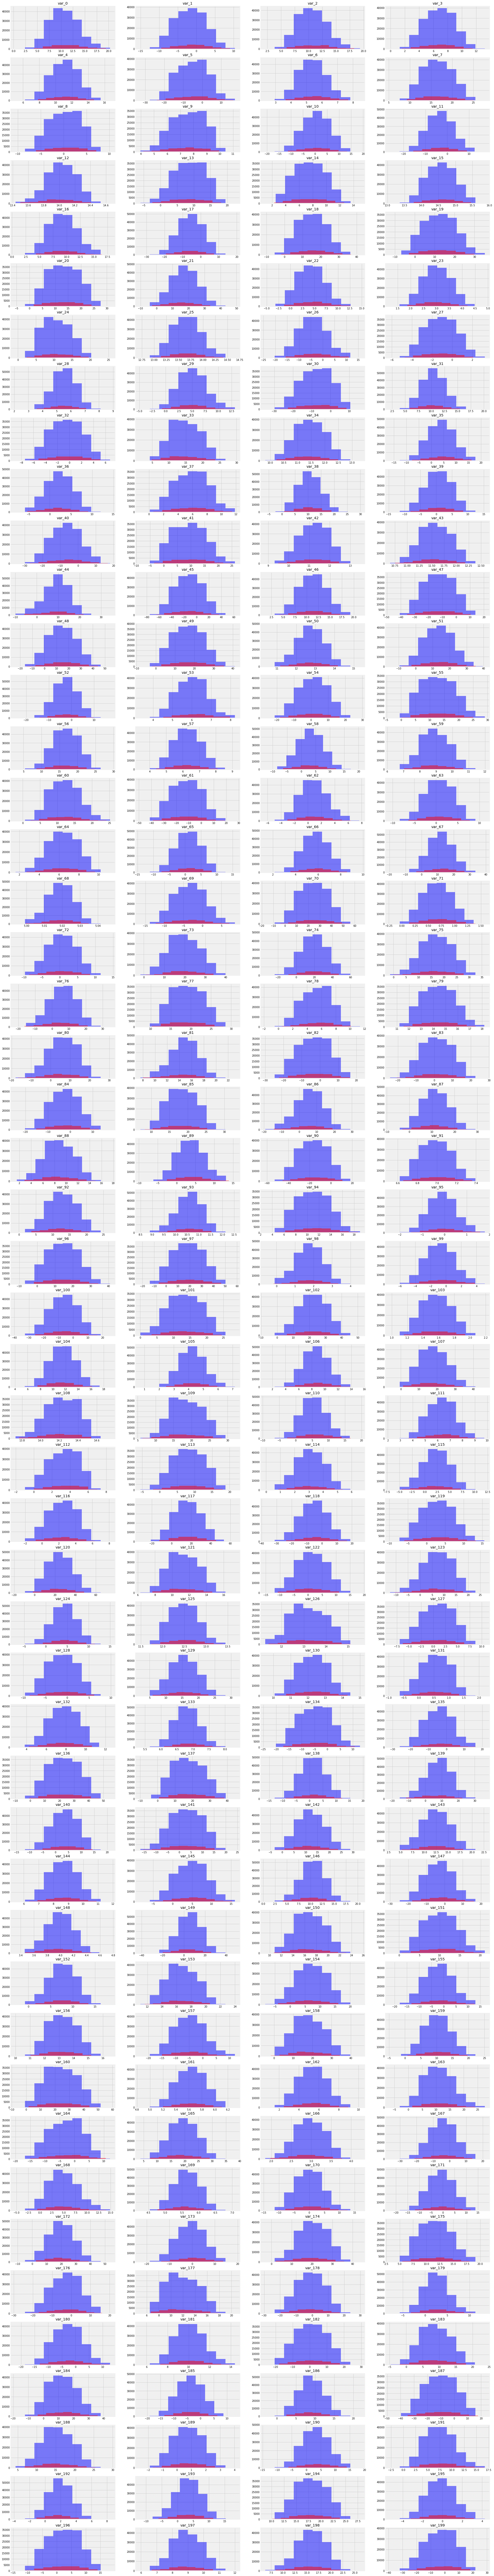

In [12]:
print('Distributions columns')
plt.figure(figsize=(30, 185))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[train["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train[train["target"] == 1][col], alpha=0.5, label='1', color='r')    
    plt.title(col)
gc.collect();

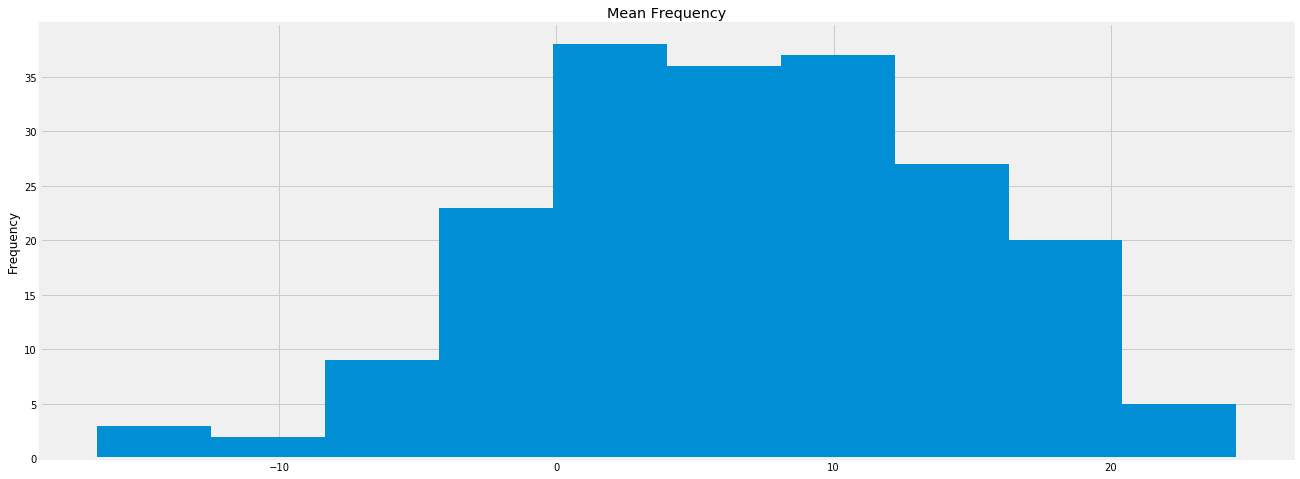

In [13]:
plt.figure(figsize=(20, 8))
train[numerical_features].mean().plot('hist');
plt.title('Mean Frequency');

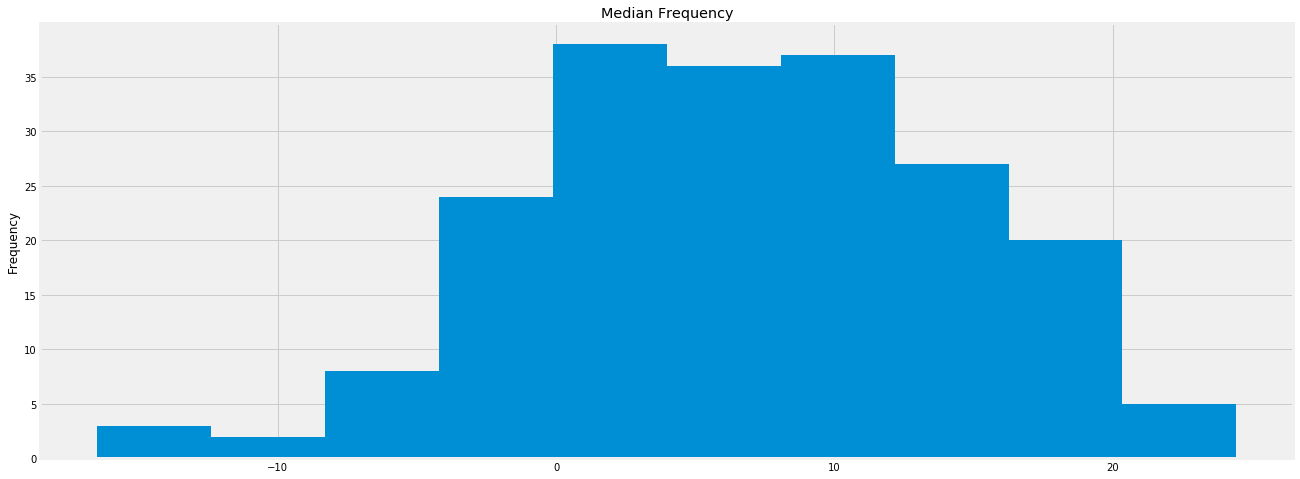

In [14]:
plt.figure(figsize=(20, 8))
train[numerical_features].median().plot('hist');
plt.title('Median Frequency');

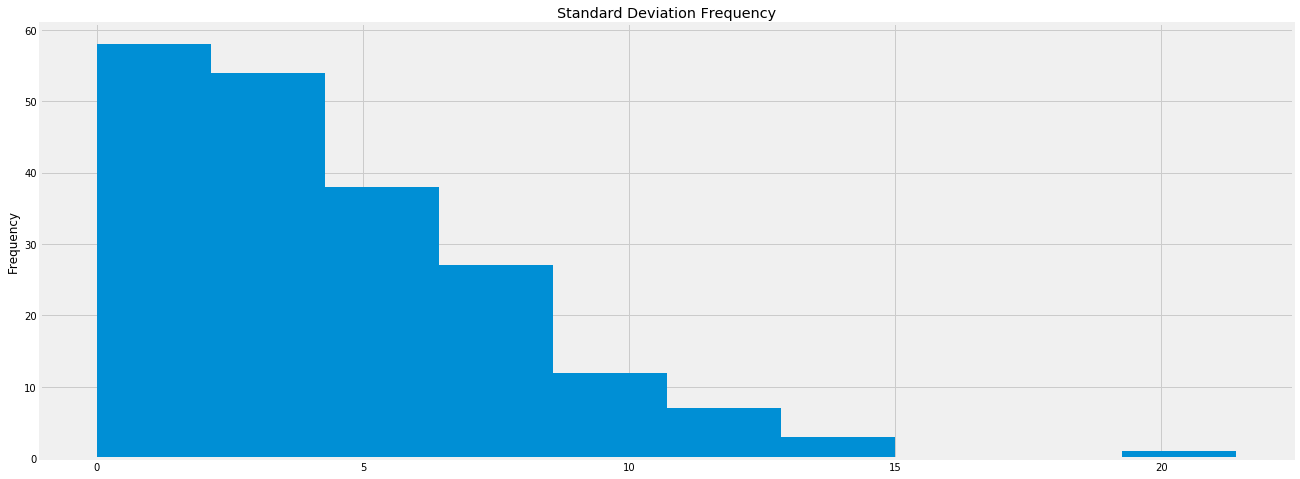

In [15]:
plt.figure(figsize=(20, 8))
train[numerical_features].std().plot('hist');
plt.title('Standard Deviation Frequency');

Most of the distributions show small std. deviations, and very few more than 20. Maybe a log transformation or a scaling technique to all features will alter the graph above to a normal one. 

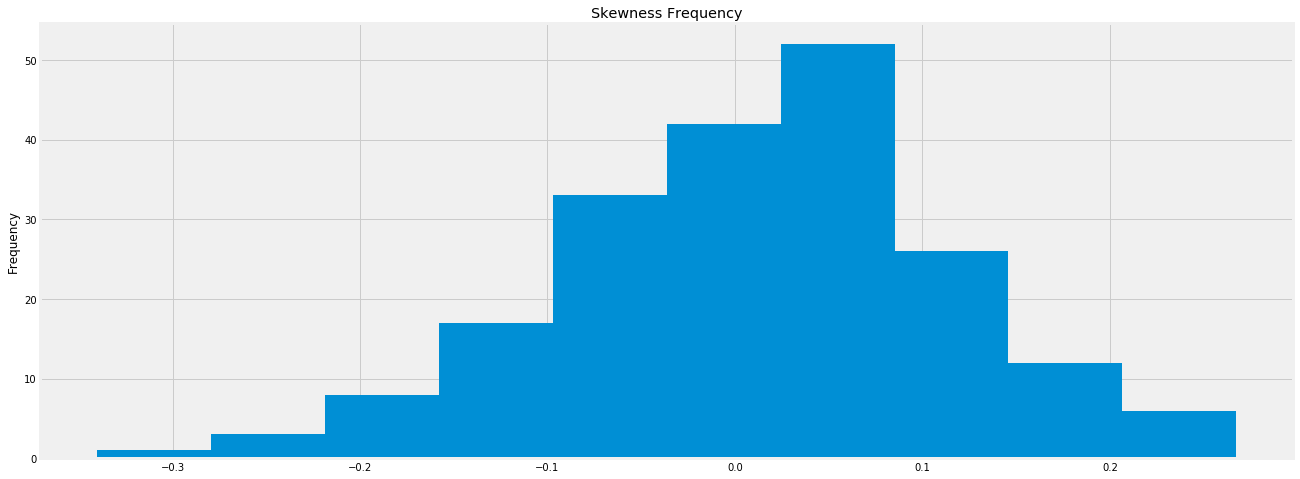

In [16]:
plt.figure(figsize=(20, 8))
train[numerical_features].skew().plot('hist');
plt.title('Skewness Frequency');

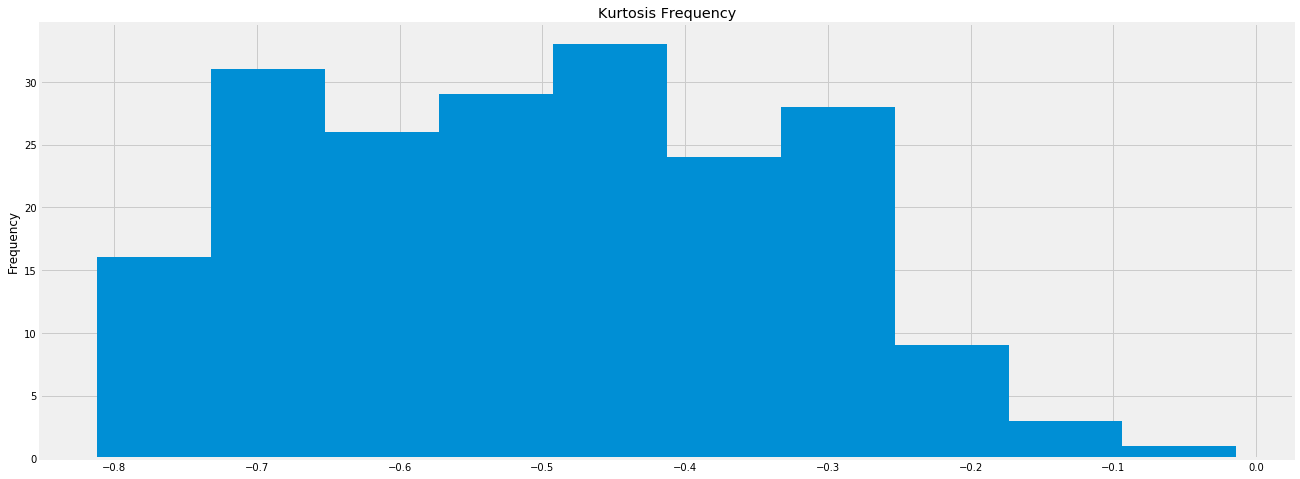

In [17]:
plt.figure(figsize=(20, 8))
train[numerical_features].kurt().plot('hist');
plt.title('Kurtosis Frequency');

Both Skewness and Kurtosis show that the features distributions are like a normal one.

#### correlations between numerical data

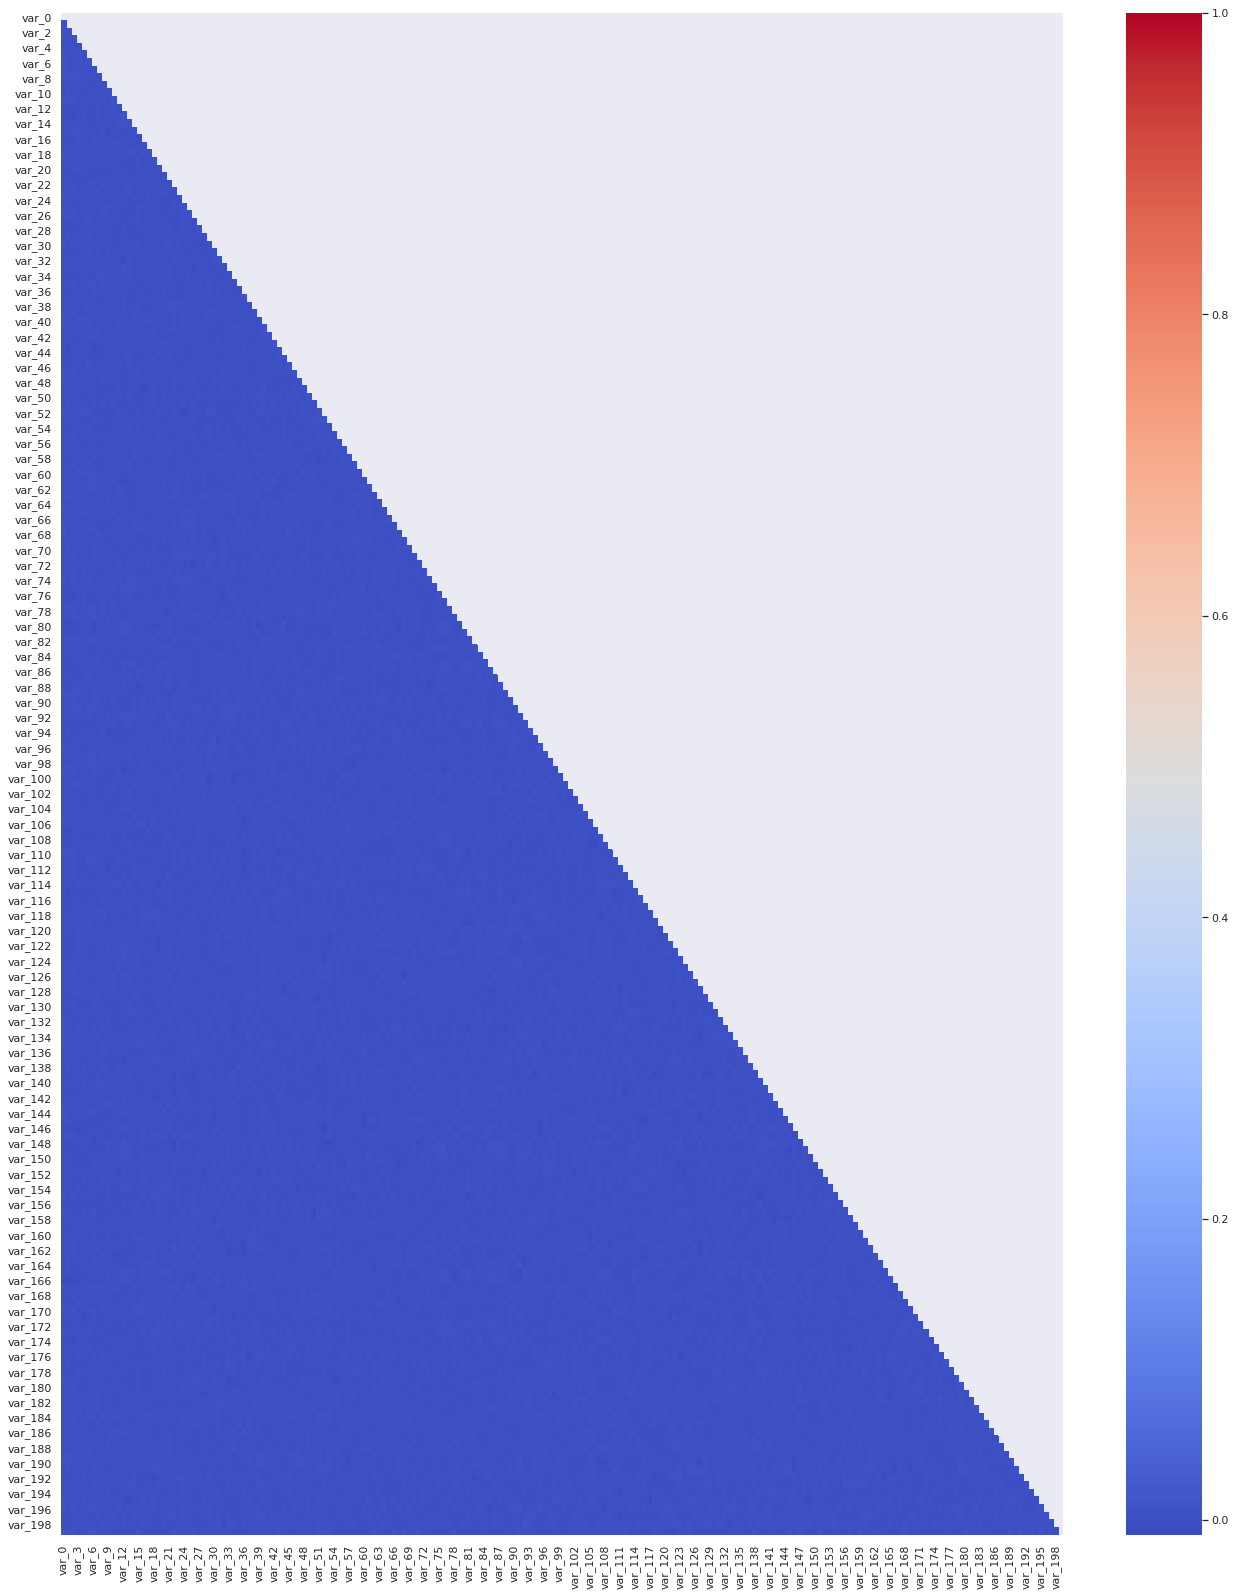

In [18]:
sns.set(rc={'figure.figsize':(20,28)})

# Compute the correlation matrix
corr = train[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            #annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

the figure above shows that most of the pearson correlations between the numerical data are close to zero, in fact is between 0 and 0.2. That means that most of the numerical data are almost uncorrelated between them.

#### Most correlated features:

In [19]:
s = corr.unstack().drop_duplicates()
so = s.sort_values(kind="quicksort")
so = so.drop_duplicates()

print("Top most highly positive correlated features:")
print(so[(so<1) & (so>0.5)].sort_values(ascending=False))

print()

print("Top most highly megative correlated features:")
print(so[(so < - 0.005)])

Top most highly positive correlated features:
Series([], dtype: float64)

Top most highly megative correlated features:
var_26   var_139   -0.009844
var_53   var_148   -0.009788
var_6    var_80    -0.008958
var_1    var_80    -0.008855
var_2    var_13    -0.008795
var_81   var_155   -0.008601
var_127  var_162   -0.008555
var_54   var_179   -0.008394
var_26   var_72    -0.008062
var_34   var_133   -0.008020
var_10   var_163   -0.008002
var_2    var_80    -0.007989
var_148  var_195   -0.007932
var_34   var_138   -0.007869
var_50   var_157   -0.007859
var_67   var_169   -0.007842
var_12   var_99    -0.007828
var_91   var_165   -0.007819
var_166  var_191   -0.007798
var_139  var_170   -0.007749
         var_155   -0.007554
var_26   var_166   -0.007532
var_111  var_197   -0.007517
var_169  var_191   -0.007492
var_177  var_179   -0.007454
var_0    var_123   -0.007402
var_162  var_198   -0.007391
var_32   var_198   -0.007375
var_18   var_192   -0.007355
var_0    var_166   -0.007269
          

### EDA Summary

- We have 200 features that are mostly uncorrelated between them
- 200 numerical features that their histograms have a shape like the one of a normal distribution

## Machine Learning Modeling

![](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)
[image-source](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)

### Feature Engineering

In [20]:
gc.collect();
for df in [test, train]:
    df['sum'] = df[numerical_features].sum(axis=1)  
    df['min'] = df[numerical_features].min(axis=1)
    df['max'] = df[numerical_features].max(axis=1)
    df['mean'] = df[numerical_features].mean(axis=1)
    df['std'] = df[numerical_features].std(axis=1)
    df['skew'] = df[numerical_features].skew(axis=1)
    df['kurt'] = df[numerical_features].kurtosis(axis=1)
    df['med'] = df[numerical_features].median(axis=1)

In [21]:
y = train['target']
X = train.drop(['target', "ID_code"], axis=1)

In [30]:
def xgboost_all_purpose(X, y, type_of_training):
    
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import time
    import random
    
    import xgboost as xgb
    
    # xgboost parameters
    eta = 0.03
    estimators  = 8000
    depth = 6
    gamma_value = 0
    colsample_bytree_value = 1
    max_rounds = 100
    child_weight = 1
    
    if type_of_training == "baseline":
    # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)
    
        import xgboost as xgb

        start_time = time.time()

        clf_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)

        clf_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)

        predictions = clf_xgb.predict(xvalid)
        predictions_probas = clf_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        return clf_xgb
        
    elif type_of_training == "stratified":
        
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)
        
        predictions_probas_list = []
        index_fold = 0
        best_score = 1
        
        folds = StratifiedKFold(n_splits=3, shuffle=True, random_state = 42)
        
        clf_stra_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

            print("Stratified Fold:", index_fold)
            index_fold = index_fold + 1
            
            import xgboost as xgb

            start_time = time.time()


            clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                        early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)
            
            #if (clf_stra_xgb.best_score < best_score):
            #    clf_best_stra_xgb = clf_stra_xgb
            #    best_score = clf_stra_xgb.best_score
            
            print()

            predictions_probas = clf_stra_xgb.predict_proba(xvalid)
            predictions_probas_list.append(predictions_probas)
            
        
        predictions_probas=[sum(i)/index_fold for i in zip(*predictions_probas_list)]
        predictions = np.argmax(predictions_probas, axis=1)
        
        #xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)
        #clf_stra_xgb = clf_best_stra_xgb
        #del clf_best_stra_xgb
        #print("Best score:", best_score)
        
        predictions = clf_stra_xgb.predict(xvalid)
        predictions_probas = clf_stra_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8, 8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_stra_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        return clf_stra_xgb

    elif type_of_training == "oversampling":
        
        #### resampling techniques:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled
        

        start_time = time.time()

        clf_ros_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)

        clf_ros_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)

        predictions = clf_ros_xgb.predict(xvalid)
        predictions_probas = clf_ros_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8, 8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_ros_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        return clf_ros_xgb
    
    elif type_of_training == "smote":
        #### resampling techniques:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_smote_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)

        clf_smote_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)

        predictions = clf_smote_xgb.predict(xvalid)
        predictions_probas = clf_smote_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_smote_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        return clf_smote_xgb
    
    elif type_of_training == "undersampling":
        
        #### resampling techniques:
        from imblearn.under_sampling import RandomUnderSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # RandomUnderSampler
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_rus_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)

        clf_rus_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)

        predictions = clf_rus_xgb.predict(xvalid)
        predictions_probas = clf_rus_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_rus_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_rus_xgb
    
    else:
        print("Please specify for the argument 'type_of_training'one of the following parameters: (baseline, stratified, oversampling, smote, undersampling, tomek)")

In [ ]:
clf_xgb = xgboost_all_purpose(X,y, type_of_training ="baseline")

In [ ]:
rus_clf_xgb = xgboost_all_purpose(X,y, type_of_training ="undersampling")

In [ ]:
### code for testing
'''
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import time

# create a 70/30 split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

import xgboost as xgb

start_time = time.time()

clf_xgb = xgb.XGBClassifier(learning_rate=0.05, 
                            n_estimators=3000, 
                            max_depth=6,
                            min_child_weight=1,
                            gamma=0,
                            subsample=1,
                            colsample_bytree=1,
                            objective= 'binary:logistic',
                            nthread=-1,
                            scale_pos_weight=1,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            seed=42)

clf_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
            early_stopping_rounds=100, eval_metric='auc', verbose=100)

predictions = clf_xgb.predict(xvalid)

print()
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
predictions_probas = clf_xgb.predict_proba(xvalid)
print("roc-auc score", roc_auc_score(yvalid, predictions_probas[:,1]))

print()
print("elapsed time in seconds: ", time.time() - start_time)

print()
gc.collect()
'''

### Feature Selection - Permutation Importance

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=42)
rfc_model = RandomForestClassifier(random_state=42).fit(train_X, train_y)

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=42).fit(val_X, val_y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=100)

Weight,Feature
0.0004 ± 0.0002,var_139
0.0003 ± 0.0002,var_12
0.0003 ± 0.0001,var_80
0.0003 ± 0.0002,var_6
0.0003 ± 0.0002,var_26
0.0003 ± 0.0002,var_148
0.0002 ± 0.0002,var_198
0.0002 ± 0.0001,var_174
0.0002 ± 0.0001,var_170
0.0002 ± 0.0001,var_110


#### Select top 100 features after permutation importance:

In [25]:
from sklearn.feature_selection import SelectFromModel

max_selected_features = 100
sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)
X_trans = sel.transform(X)

feature_idx = sel.get_support()
feature_name = X.columns[feature_idx]

X_trans = X[feature_name]
X_trans.shape

(200000, 85)

### XGBoost Training after Feature Selection

[0]	validation_0-auc:0.652434	validation_1-auc:0.638614
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 400 rounds.
[100]	validation_0-auc:0.838826	validation_1-auc:0.775796
[200]	validation_0-auc:0.886429	validation_1-auc:0.806741
[300]	validation_0-auc:0.909064	validation_1-auc:0.817534
[400]	validation_0-auc:0.923626	validation_1-auc:0.823564
[500]	validation_0-auc:0.934487	validation_1-auc:0.82683
[600]	validation_0-auc:0.943206	validation_1-auc:0.828281
[700]	validation_0-auc:0.950297	validation_1-auc:0.829209
[800]	validation_0-auc:0.955491	validation_1-auc:0.829487
[900]	validation_0-auc:0.959934	validation_1-auc:0.829372
[1000]	validation_0-auc:0.963372	validation_1-auc:0.829343
[1100]	validation_0-auc:0.966315	validation_1-auc:0.829209
[1200]	validation_0-auc:0.969019	validation_1-auc:0.828915
Stopping. Best iteration:
[810]	validation_0-auc:0.955946	validation_1-auc:0.829562


  

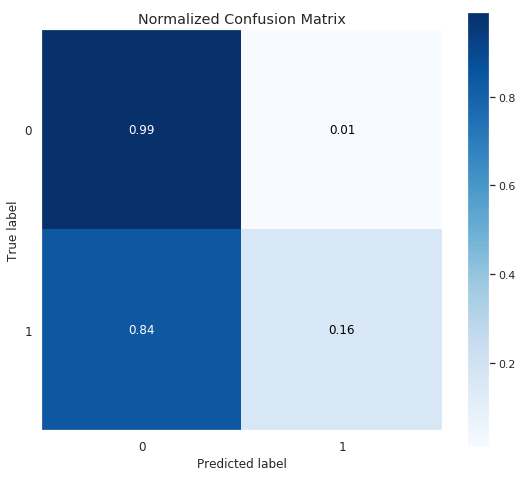

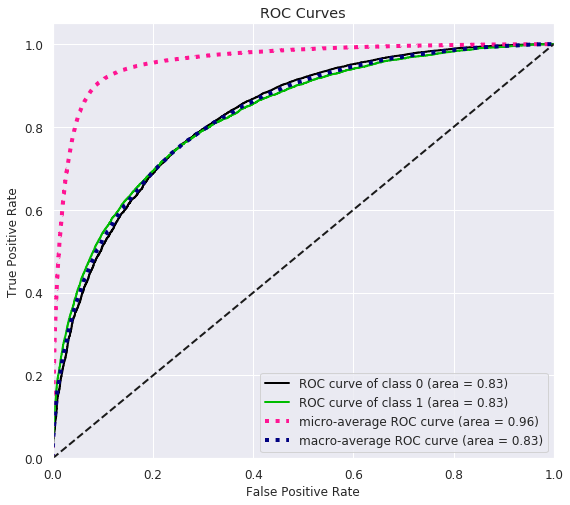

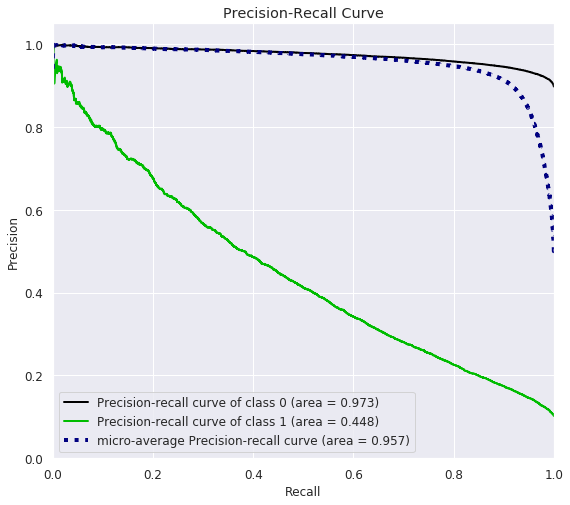

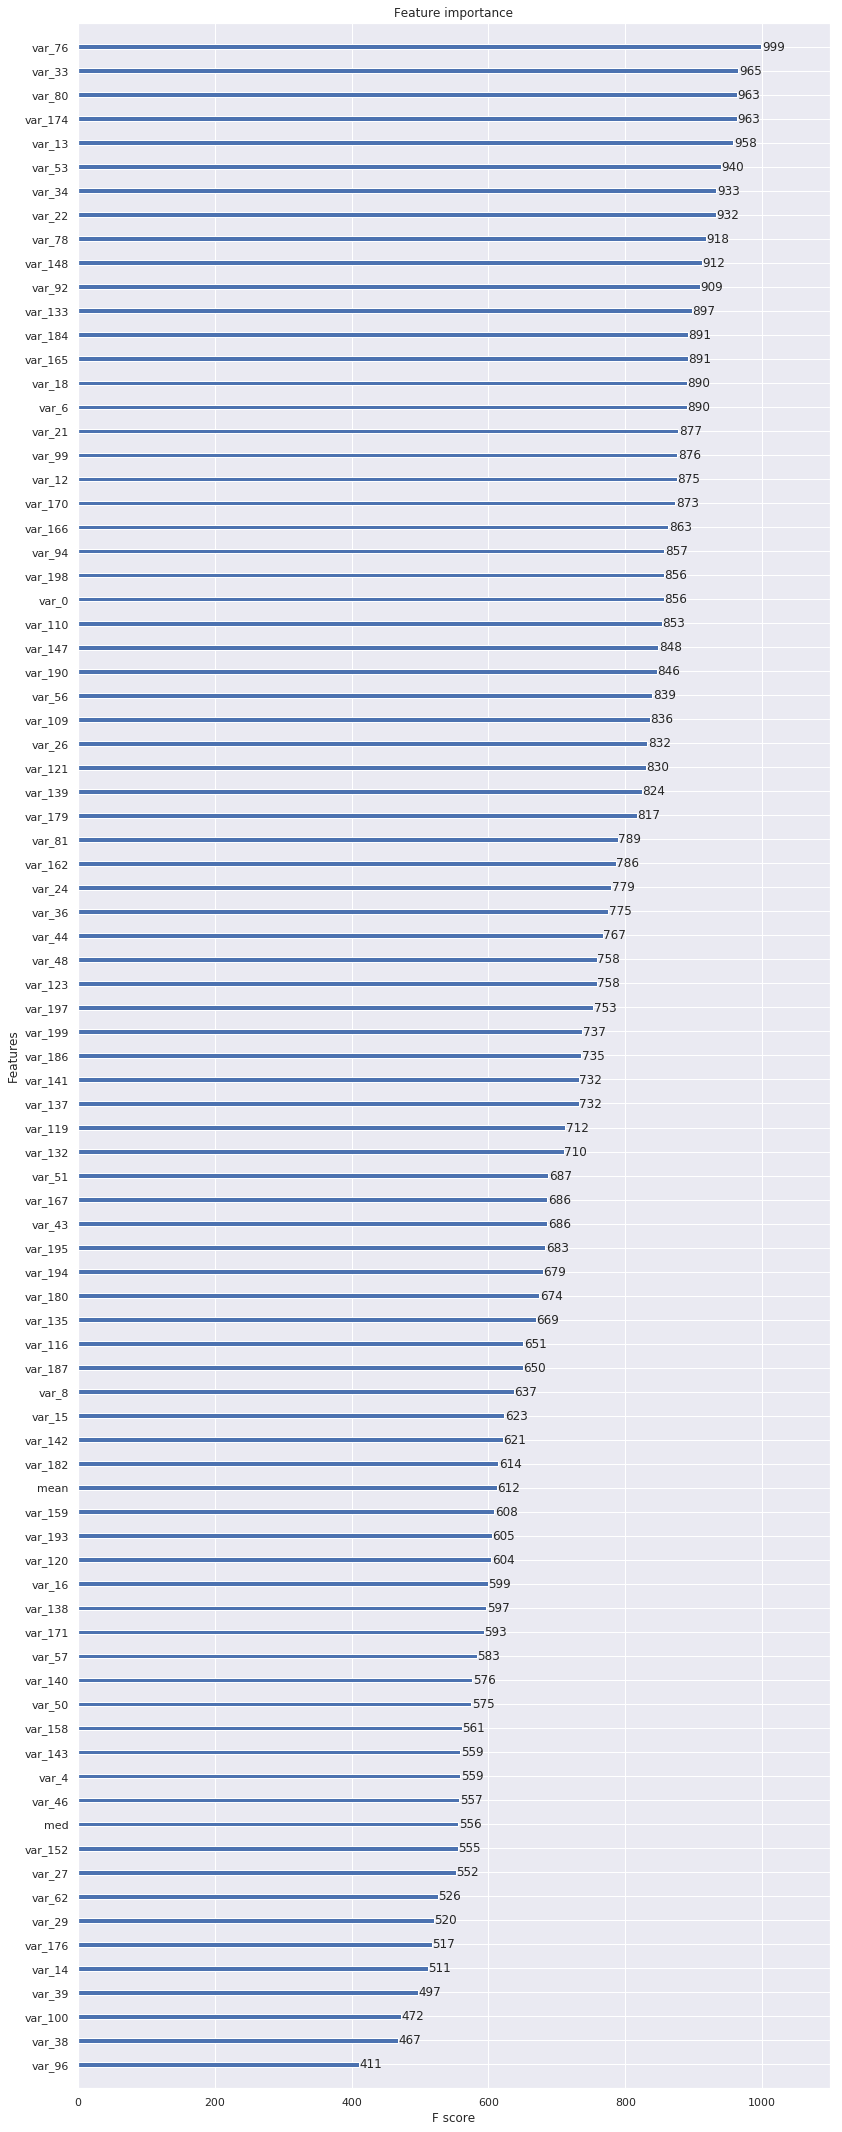

In [26]:
trans_clf_xgb = xgboost_all_purpose(X_trans,y, type_of_training ="baseline")

Using TensorFlow backend.


[0]	validation_0-auc:0.670982	validation_1-auc:0.638254
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 400 rounds.
[100]	validation_0-auc:0.892037	validation_1-auc:0.78458
[200]	validation_0-auc:0.929311	validation_1-auc:0.804079
[300]	validation_0-auc:0.950603	validation_1-auc:0.812482
[400]	validation_0-auc:0.96443	validation_1-auc:0.816941
[500]	validation_0-auc:0.973481	validation_1-auc:0.819244
[600]	validation_0-auc:0.980283	validation_1-auc:0.820119
[700]	validation_0-auc:0.985274	validation_1-auc:0.82037
[800]	validation_0-auc:0.988987	validation_1-auc:0.820496
[900]	validation_0-auc:0.9917	validation_1-auc:0.8203
[1000]	validation_0-auc:0.993637	validation_1-auc:0.820137
[1100]	validation_0-auc:0.995252	validation_1-auc:0.81981
Stopping. Best iteration:
[776]	validation_0-auc:0.988155	validation_1-auc:0.820639


              precision    recall  f1-score   support

           0 

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


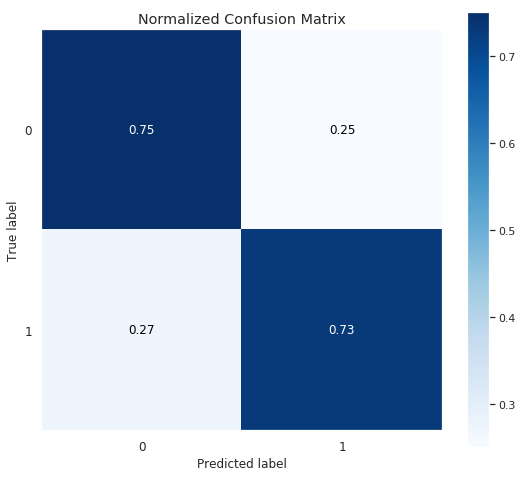

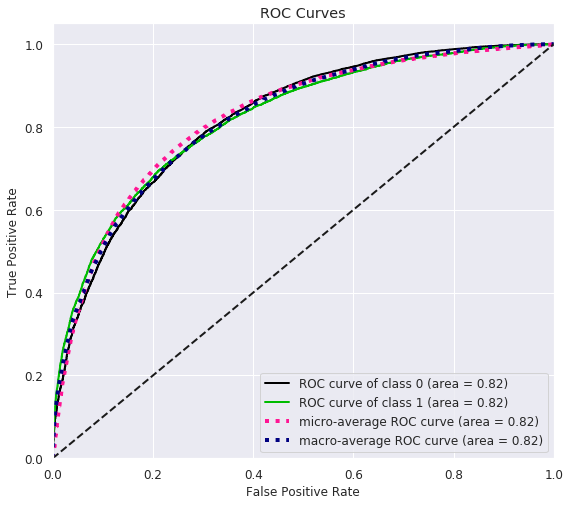

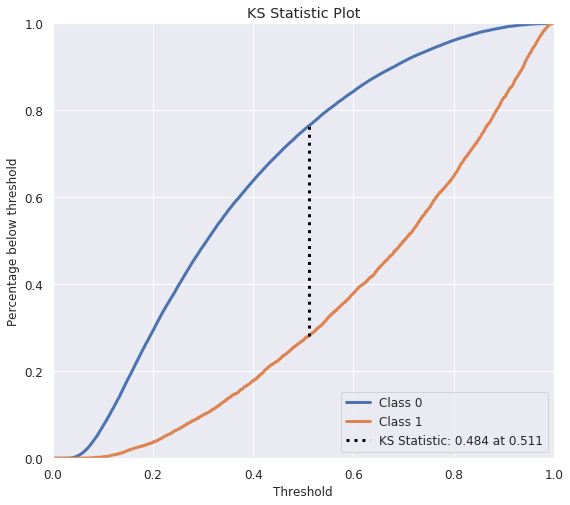

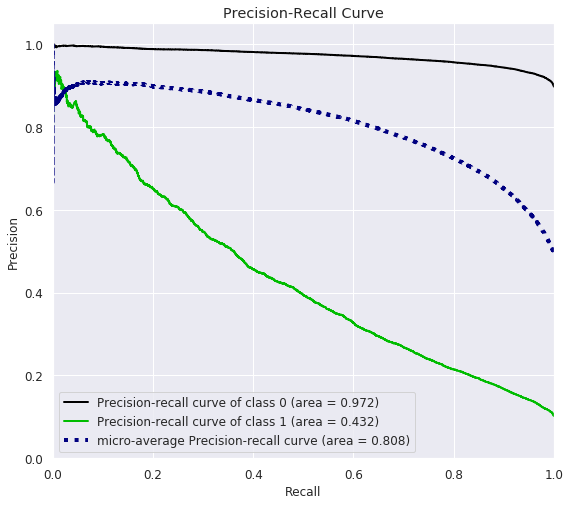

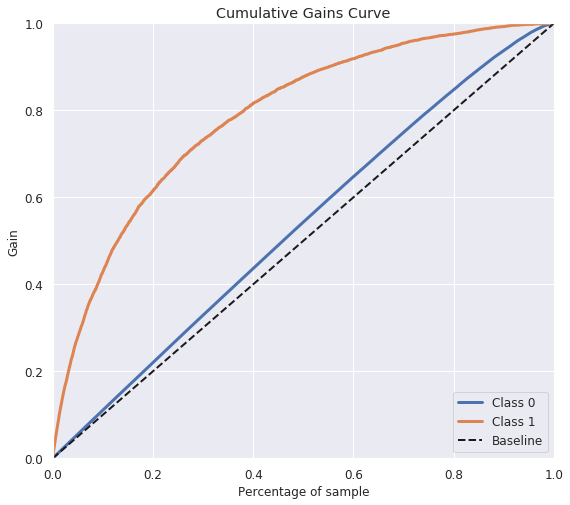

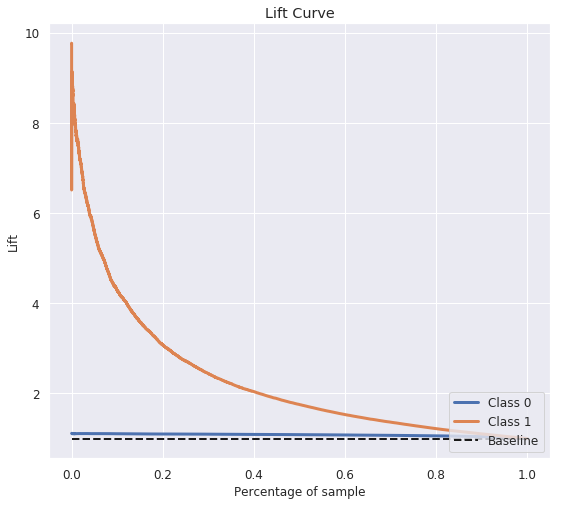

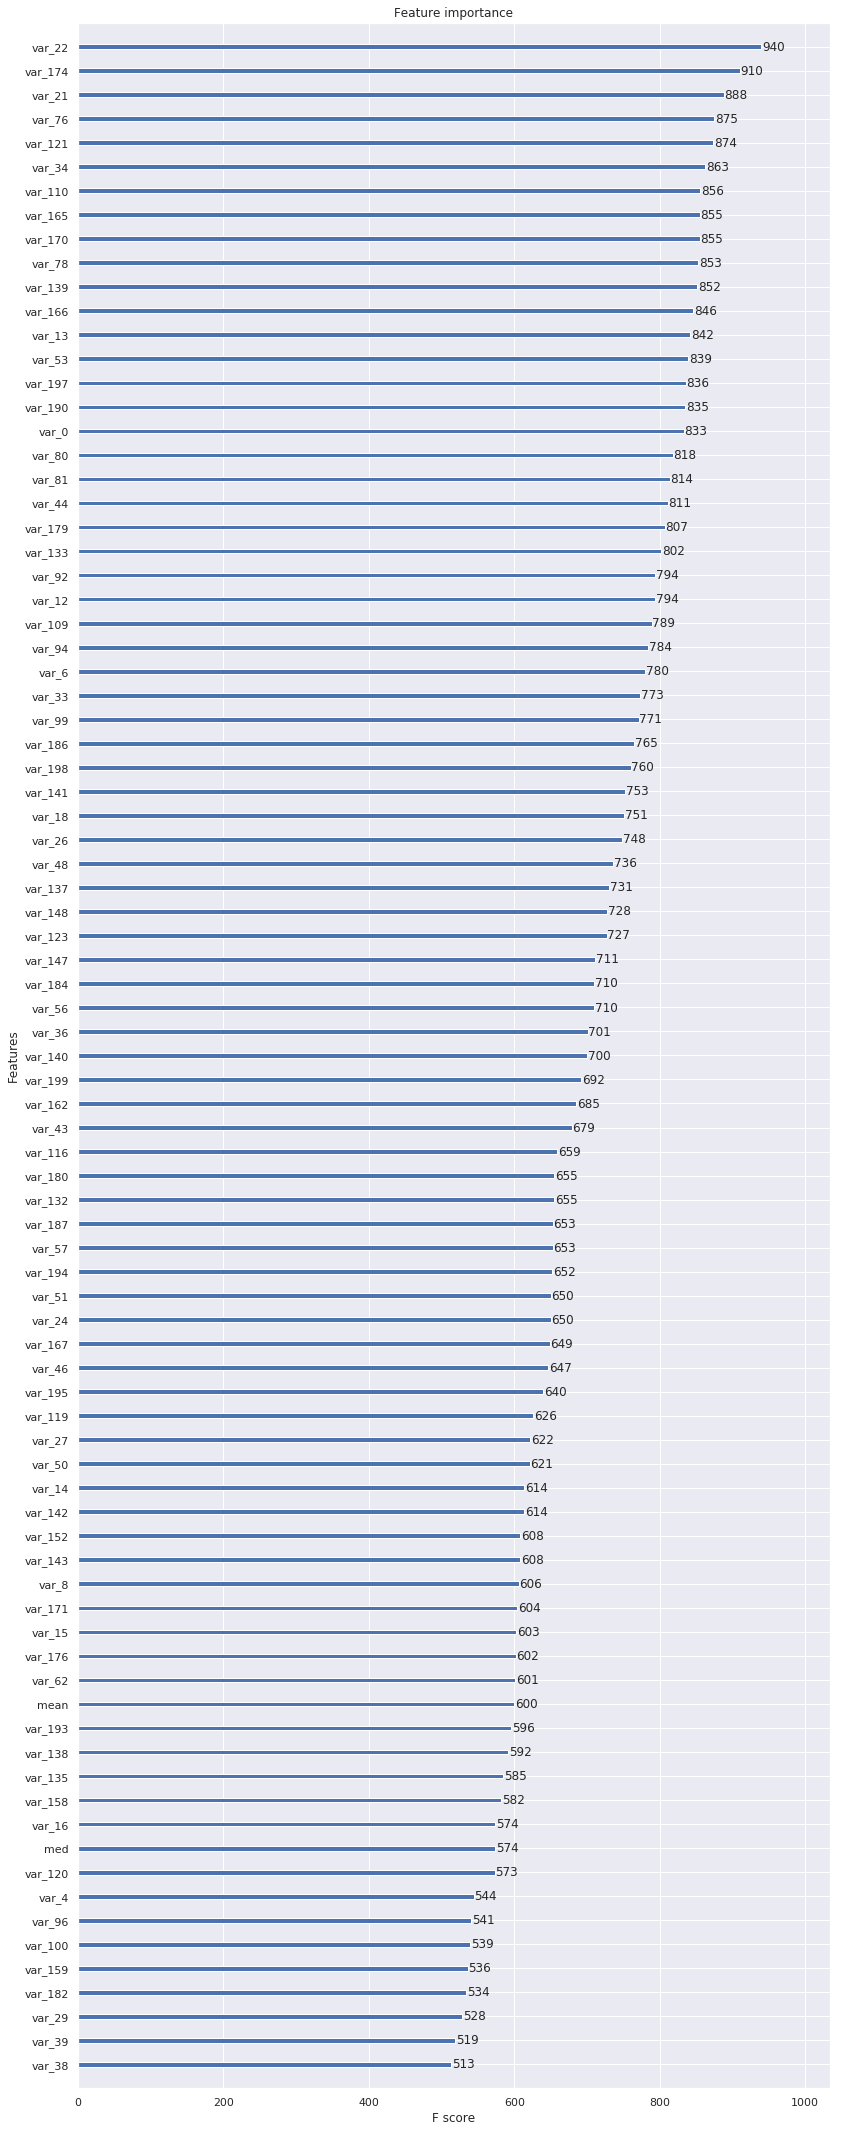

In [27]:
rus_trans_clf_xgb = xgboost_all_purpose(X_trans,y, type_of_training ="undersampling")

## ML Tuning
** To be updated **

In [36]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X_trans, y, random_state=42, test_size=0.3)

from imblearn.under_sampling import RandomUnderSampler

# RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

xtrain=pd.DataFrame(X_resampled, columns = X_trans.columns)
ytrain = y_resampled

[(0, 13954), (1, 13954)]


In [ ]:
# I am afraid of variance - bias tradeoff

import xgboost as xgb

#idea and a big thank you to https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
from sklearn.model_selection import GridSearchCV   #Perforing grid search

gc.collect()

param_test1 = {
 'max_depth':[6, 7, 8, 9, 10],
 'min_child_weight':[1, 3, 5, 7, 9]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.03, n_estimators=60, gamma=0, subsample=1, colsample_bytree=1,
                                                  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, reg_alpha = 0, 
                                                reg_lambda =1, seed=42), 
                        param_grid = param_test1, scoring='roc_auc', n_jobs=1, iid=False, cv=3, verbose = 1)

gsearch1.fit(xtrain, ytrain)
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
best_params_1 = gsearch1.best_params_
print(best_params_1)
del gsearch1
gc.collect()

## ML Blends
** To be updated **

## Preparing for submmission

In [ ]:
gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = clf_xgb.predict(test.drop("ID_code", axis="columns"))
submission.to_csv('xgboost.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = clf_rus_xgb.predict(test.drop("ID_code", axis="columns"))
submission.to_csv('xgboost_rus.csv', index=False)


gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = trans_clf_xgb.predict(test.drop("ID_code", axis="columns"))
submission.to_csv('xgboost_trans.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = rus_trans_clf_xgb.predict(test.drop("ID_code", axis="columns"))
submission.to_csv('xgboost_trans_xgb.csv', index=False)

## Conclusion
We can see from EDA and ML Modeling that class #1 is very unbalanced and difficult to identified and classified.